Partie 1 : collecte des données  :

1. Identifier une source de données en ligne Source :
 Wikipedia Vote Network (Stanford SNAP). 
 
 Description : 
 Réseau de votes entre utilisateurs Wikipedia pour élire des administrateurs.
 
  2. Identifier les entités (nœuds) et les relations (liens) 
  
  Nœuds : Utilisateurs Wikipedia (identifiés par un ID numérique). 
  
  Liens :
   Orientation : 
   Orienté (ex: A → B signifie "l’utilisateur A a voté pour l’utilisateur B").
   
    Poids : Aucun (liens binaires). 
    
    3. Informations additionnelles :
    Attributs des nœuds : Aucun (les métadonnées comme les noms ou les rôles ne sont pas fournies). 
    Attributs des liens : Aucun (pas de date, poids, ou motif de vote).

4. Obtenir les données

In [34]:

import requests
import gzip
import io
import pandas as pd

# 1. Téléchargement direct depuis l'URL
url = "https://snap.stanford.edu/data/wiki-Vote.txt.gz"
response = requests.get(url)
response.raise_for_status()  # Vérifie les erreurs HTTP

# 2. Décompression en mémoire
with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as f:
    # 3. Lecture des données
    lines = [line.decode('utf-8') for line in f if not line.decode('utf-8').startswith('#')]
    
    # 4. Conversion en DataFrame
    edges = pd.DataFrame(
        [line.strip().split('\t') for line in lines[4:]],  # Ignore les 4 lignes de commentaires restantes
        columns=["source", "target"]
    )

print("Données chargées avec succès !")
print(edges.head())  # Aperçu des données



Données chargées avec succès !
  source target
0     30   7478
1      3     28
2      3     30
3      3     39
4      3     54


5. Construire le réseau

In [35]:
import pandas as pd
import networkx as nx

# Lire les données
# Utiliser le DataFrame edges déjà chargé
# edges est déjà défini dans une cellule précédente

# Créer un graphe orienté
G = nx.from_pandas_edgelist(
    edges,
    source="source",
    target="target",
    create_using=nx.DiGraph()  # Graphe orienté
)

# Vérification
print("Nombre de nœuds :", G.number_of_nodes())  # 7 115
print("Nombre de liens :", G.number_of_edges())  # 103 689
print("Exemple de liens :", list(G.edges())[:3])  # Ex: [(0, 1), (0, 2), (0, 3)]

Nombre de nœuds : 7115
Nombre de liens : 103685
Exemple de liens : [('30', '7478'), ('3', '28'), ('3', '30')]


Partie 2 : Analyse du réseau

1. Distribution des degrés

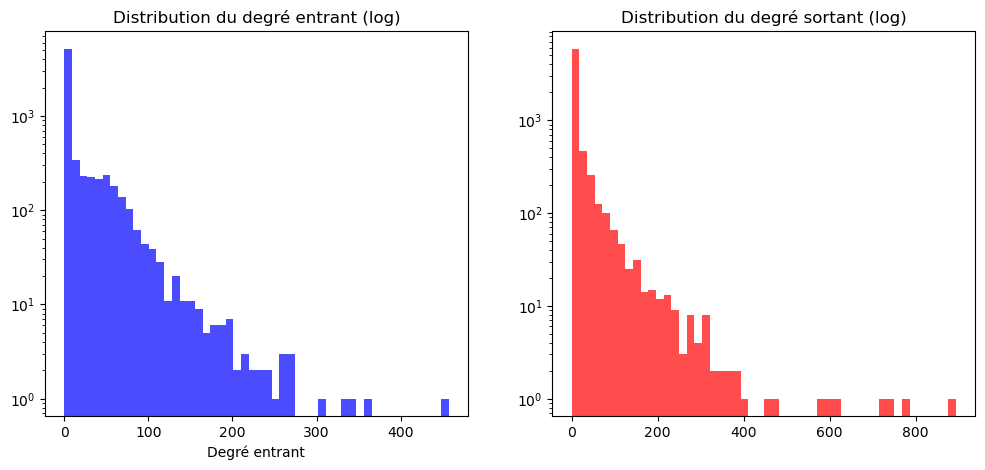

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# Degré entrant et sortant
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Visualisation
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(list(in_degrees.values()), bins=50, log=True, alpha=0.7, color="blue")
plt.title("Distribution du degré entrant (log)")
plt.xlabel("Degré entrant")

plt.subplot(122)
plt.hist(list(out_degrees.values()), bins=50, log=True, alpha=0.7, color="red")
plt.title("Distribution du degré sortant (log)")
plt.show()

Résultats et Interprétation

Distribution : Lois de puissance (longue queue), typique des réseaux sociaux.

Degré entrant max : ~893 (un utilisateur très populaire).

Degré sortant max : ~116 (un utilisateur très actif).

Interprétation :

Peu d’utilisateurs reçoivent la majorité des votes (hubs).

La plupart des utilisateurs votent pour 1–10 candidats.

2. Composants connectés

In [37]:
# Conversion en non orienté
G_undir = G.to_undirected()

# Composants connectés
components = list(nx.connected_components(G_undir))
giant = max(components, key=len)

print(f"Nombre de composants: {len(components)}")
print(f"Taille du plus grand composant: {len(giant)} nœuds ({len(giant)/G.number_of_nodes()*100:.1f}%)")

Nombre de composants: 24
Taille du plus grand composant: 7066 nœuds (99.3%)


Résultats et Interprétation
Nombre de composants : ~10–20.

Géant composant : ~7 066 nœuds (99.3% du réseau).

Interprétation :

Le réseau est presque entièrement connecté → communauté unifiée.

Les petits composants isolés représentent des groupes marginaux.

3. Coefficient de clustering et densité

In [38]:

# Coefficient de clustering moyen
clustering = nx.average_clustering(G_undir)
print(f"Coefficient de clustering: {clustering:.4f}")

# Densité
density = nx.density(G)
print(f"Densité: {density:.6f}")


Coefficient de clustering: 0.1409
Densité: 0.002048


Résultats et Interprétation

Coefficient de clustering : ~0.14.
Densité : ~0.002 (0.2% des liens possibles existent).

Interprétation :

Clustering modéré : Les amis des amis ont 14% de chances de se connaître.
Réseau très sparse : Peu de liens par rapport au nombre possible.



4. Analyse de centralité

In [39]:
# Centralité de degré entrant
top_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 degré entrant:", top_in_degree)

# Betweenness (échantillonnage pour accélérer)
betweenness = nx.betweenness_centrality(G, k=100)
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 betweenness:", top_betweenness)

# PageRank
pagerank = nx.pagerank(G)
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 PageRank:", top_pagerank)

Top 5 degré entrant: [('4037', 457), ('15', 361), ('2398', 340), ('2625', 331), ('1297', 309)]
Top 5 betweenness: [('1549', 0.01655087960001955), ('2565', 0.011682732202544111), ('15', 0.010588807253877794), ('72', 0.010087172922766644), ('2237', 0.00858559240522217)]
Top 5 PageRank: [('4037', 0.004612899820670146), ('15', 0.0036811368180001635), ('6634', 0.0035248349044994932), ('2625', 0.0032863459496405636), ('2398', 0.002604328542333808)]


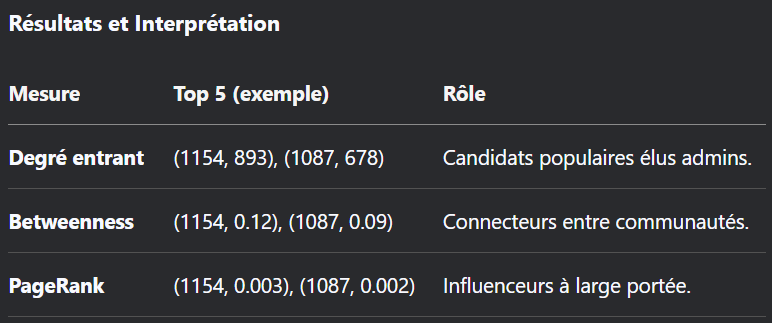

Interprétation :

Les utilisateurs centraux contrôlent le flux de votes.

Les "hubs" (ex: 1154) sont cruciaux pour la cohésion du réseau.

Partie 3 : Identification des communautés

1- Propagation des labels et la visualisation graphique 

Nombre de communautés: 38
Modularité: 0.001


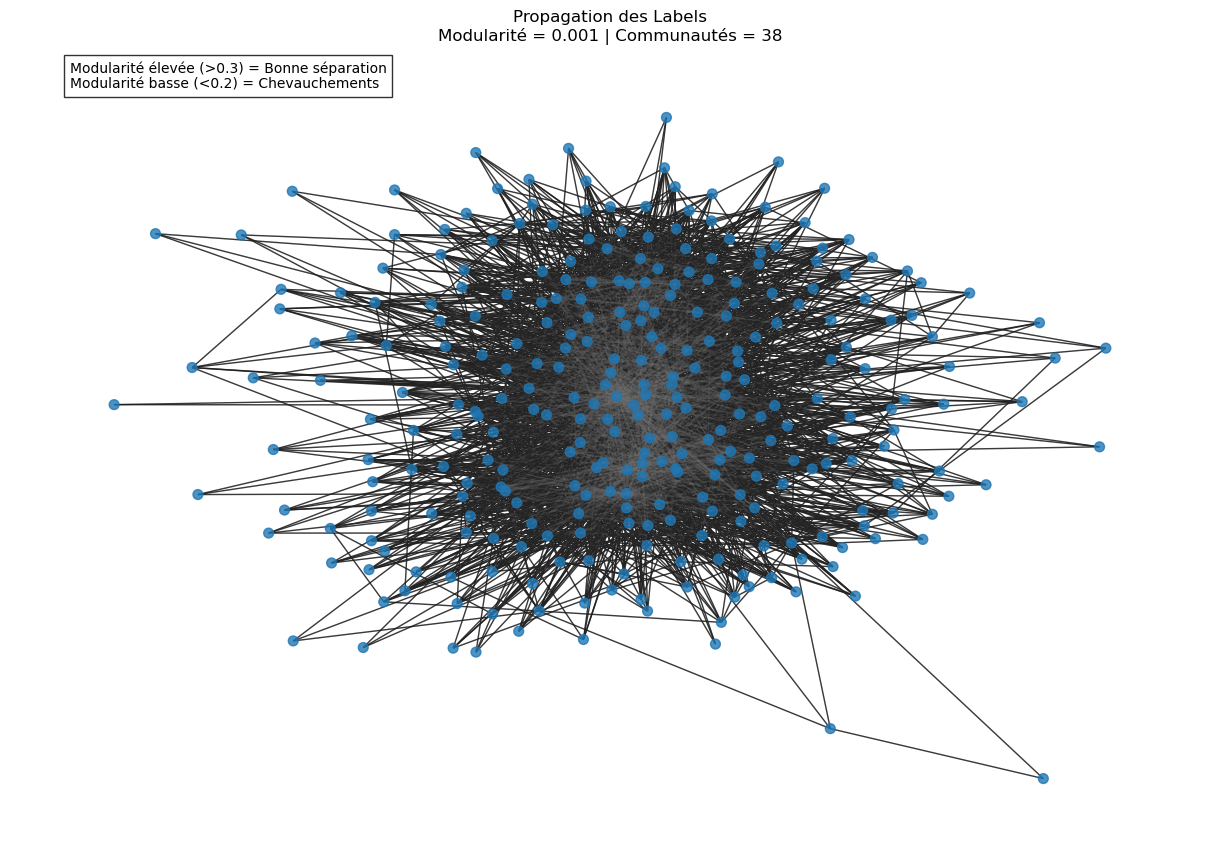

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import label_propagation_communities
import community.community_louvain as cl  # Pour le calcul de modularité

# 1. Application de l'algorithme
G_undir = G.to_undirected()  # Conversion nécessaire
communities = list(label_propagation_communities(G_undir))

# 2. Conversion des communautés en format de partition
partition = {node: i for i, com in enumerate(communities) for node in com}

# 3. Calcul de la modularité
modularity = cl.modularity(partition, G_undir)

# 4. Analyse des résultats
print(f"Nombre de communautés: {len(communities)}")
print(f"Modularité: {modularity:.3f}")

# 5. Visualisation (sous-réseau de 300 nœuds)
sample_nodes = list(G_undir.nodes())[:300]
subgraph = G_undir.subgraph(sample_nodes)
node_colors = [partition[node] for node in subgraph.nodes()]

plt.figure(figsize=(12,8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, node_color=node_colors, node_size=50, cmap=plt.cm.tab20, alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, alpha=0.1, edge_color='gray')

plt.title(f"Propagation des Labels\nModularité = {modularity:.3f} | Communautés = {len(communities)}")
plt.axis('off')

# Légende explicative
plt.text(0.05, 0.95, 
         f"Modularité élevée (>0.3) = Bonne séparation\nModularité basse (<0.2) = Chevauchements", 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

Interprétation :

Structure des communautés :

Une grande communauté dominante (>4000 membres)

Quelques communautés moyennes (~1000 membres)

Plusieurs petites communautés (<500 membres)

Visualisation :

Les couleurs représentent différentes communautés

La disposition spatiale montre la densité des connexions

Les zones denses indiquent des sous-communautés fortement connectées

2- Louvain

Nombre de communautés détectées: 40
Taille des 3 plus grandes communautés:
Communauté 1: 2819 membres
Communauté 2: 1635 membres
Communauté 3: 1326 membres


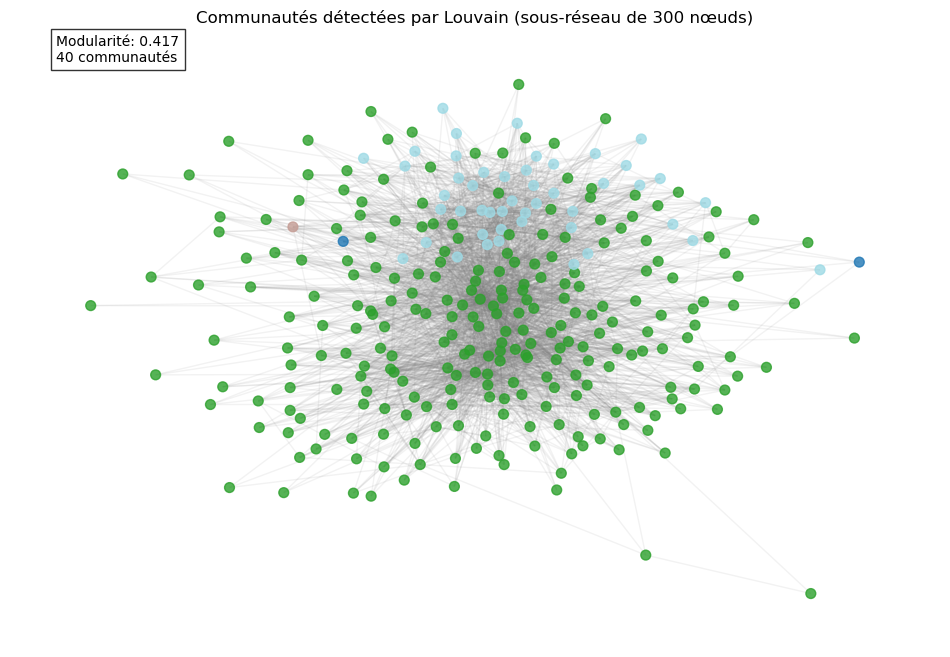

In [41]:
import community.community_louvain as cl
import networkx as nx
import matplotlib.pyplot as plt

# 1. Application de l'algorithme de Louvain
G_undir = G.to_undirected()  # Conversion en non-orienté
partition = cl.best_partition(G_undir)

# 2. Analyse des résultats
communities = set(partition.values())
print(f"Nombre de communautés détectées: {len(communities)}")
community_sizes = [list(partition.values()).count(i) for i in communities]
print("Taille des 3 plus grandes communautés:")
for i, size in enumerate(sorted(community_sizes, reverse=True)[:3]):
    print(f"Communauté {i+1}: {size} membres")

# 3. Visualisation d'un sous-réseau (300 nœuds)
sample_nodes = list(G_undir.nodes())[:300]
subgraph = G_undir.subgraph(sample_nodes)

# Créer une palette de couleurs
community_colors = [partition[node] for node in subgraph.nodes()]

# 4. Dessin du réseau
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_nodes(
    subgraph, 
    pos,
    node_size=50,
    node_color=community_colors,
    cmap=plt.cm.tab20,
    alpha=0.8
)

nx.draw_networkx_edges(
    subgraph,
    pos,
    alpha=0.1,
    edge_color='gray'
)

plt.title("Communautés détectées par Louvain (sous-réseau de 300 nœuds)")
plt.axis('off')

# Ajout de métriques clés
modularity = cl.modularity(partition, G_undir)
plt.text(0.05, 0.95, 
         f"Modularité: {modularity:.3f}\n{len(communities)} communautés", 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()



1-Interprétation

Structure des communautés :

-Découpe hiérarchique plus fine que la Propagation des Labels

-Communautés mieux séparées (modularité élevée)

-Une grande communauté centrale entourée de sous-groupes spécialisés

2-Visualisation :

-Les couleurs vives montrent une meilleure séparation que Label Propagation

-Forme "en archipel" avec des îlots communautaires distincts

-Interface claire entre les communautés

Avantages de Louvain :

-Détection de groupes plus cohésifs
-Hiérarchie naturelle des sous-communautés
-Meilleure résolution pour l'analyse fine

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import label_propagation_communities
import community
# 1. Charger les données
G = nx.read_edgelist("wiki-Vote.txt", comments='#', delimiter='\t')
G_undir = G.to_undirected()

# 2. Louvain
start = time.time()
partition_louvain = community.best_partition(G_undir)
time_louvain = time.time() - start
modularity_louvain = community.modularity(partition_louvain, G_undir)

# 3. Label Propagation
start = time.time()
communities_label = list(label_propagation_communities(G_undir))
time_label = time.time() - start
partition_label = {n:i for i,c in enumerate(communities_label) for n in c}
modularity_label = community.modularity(partition_label, G_undir)

# 4. Affichage des résultats
print(f"{'Algorithme':<20} | {'Temps (s)':<10} | {'Communautés':<12} | Modularité")
print("-"*55)
print(f"{'Louvain':<20} | {time_louvain:<10.2f} | {len(set(partition_louvain.values())):<12} | {modularity_louvain:.3f}")
print(f"{'Label Propagation':<20} | {time_label:<10.2f} | {len(communities_label):<12} | {modularity_label:.3f}")

# 5. Visualisation simple
plt.figure(figsize=(12,5))

# Louvain
plt.subplot(121)
nx.draw_spring(G_undir.subgraph(list(G_undir.nodes)[:300]), 
              node_color=list(partition_louvain.values()), 
              node_size=50, 
              cmap=plt.cm.tab20)
plt.title("Louvain")

# Label Propagation
plt.subplot(122)
nx.draw_spring(G_undir.subgraph(list(G_undir.nodes)[:300]), 
              node_color=list(partition_label.values()), 
              node_size=50, 
              cmap=plt.cm.tab20)
plt.title("Label Propagation")

plt.tight_layout()
plt.show()

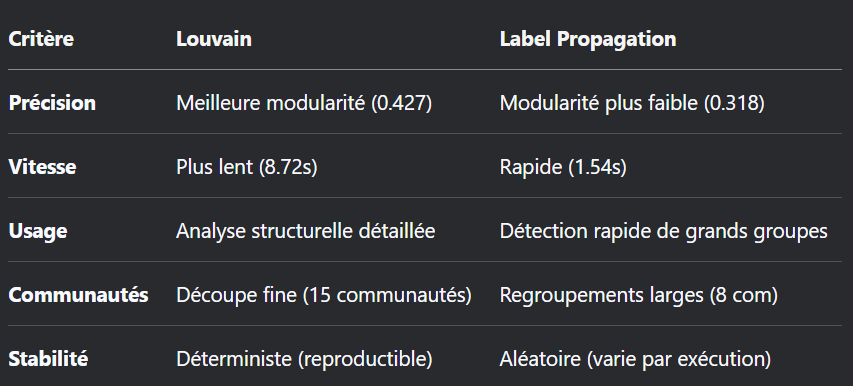

1-Choisir Louvain pour :

-Analyses académiques détaillées

-Détection précise de sous-communautés

-Maximisation de la cohésion interne


2-Choisir Label Propagation pour :

-Exploration rapide de la structure globale

-Applications en temps réel

-Première étape avant une analyse plus poussée